# Data Preprocessing

In [1]:
# !pip install pycaret
# !pip install catboost xgboost optuna

# !pip install --force-reinstall threadpoolctl 
# ^ This WORKED in fixing the "knn_impute()" - related error

In [2]:
import numpy as np # Linear algebra
import pandas as pd # DataFrame manipulation
pd.options.display.max_columns = 500 
pd.options.display.max_rows = 10

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid') # This makes our plots pretty, but it's completely unnecessary 

from sklearn.neighbors import KNeighborsRegressor # KNeighborsRegressor is used for numeric imputation purposes
import scipy.stats
from sklearn.preprocessing import StandardScaler # StandardScaler is used for numeric scaling purposes
from pycaret.regression import setup, compare_models # Pycaret is a lovely "low/no-code" tool to aid us in our model selection(s)
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score # cross_val_score measures a model's performance

from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

# import optuna # Optuna is a quicker alternative to GridSearchCV; an impatient person's dream!

In [3]:
train0 = pd.read_csv('/Users/joshuaconde/GitHub-REPOSITORIES/Kaggle-HousePricePredictions/HousePricePredictions/train.csv')
test0 = pd.read_csv('/Users/joshuaconde/GitHub-REPOSITORIES/Kaggle-HousePricePredictions/HousePricePredictions/test.csv')

sample_submission = pd.read_csv('/Users/joshuaconde/GitHub-REPOSITORIES/Kaggle-HousePricePredictions/HousePricePredictions/sample_submission.csv')

In [4]:
# train0

In [5]:
# I understand test0's not having the target variable as its final column, but why is there (in addition to this) one less row?

# test0

In [6]:
# Due to SalePrice's continuous nature, we need to derive (from memory) some kind of a regression model

# sample_submission

In [7]:
###
# DATA PREPROCESSING (CLEANING) PIPELINE:
###
# NUMERIC IMPUTATION (By means of ".mean()" and/or the "KNN" strategy) 
# CATEGORICAL IMPUTATION (Ordinal(s) = "N;" Regular Categorical(s) = ".mode()")

# NUMERIC SCALING ("StandardScaler()")
# CATEGORICAL ENCODING ("One hot encoding")

# FEATURE TRANSFORMATION (".log1p()")
# TARGET TRANSFORMATION (".log()")
# ^ Don't forget about the finishing ".exp()"

# FEATURE SELECTION - There's no need to perform this step unless the column count exceeds ~1k
# FEATURE ENGINEERING - We'll perform this following our testing the performance of at least 1 model

## 1. DataFrame Combination

In [8]:
# This early on, in the Data Preprocessing stage, it's totally valid to combine the training AND testing sets
# It's crucial, however, that we (one again) separate them come time for any model ".fit()"ing whatsoever

target = train0['SalePrice']
test_ids = test0['Id'] # This is only needed for our soon-to-come submission

train1 = train0.drop(['Id', 'SalePrice'], axis=1) 
# ^ We're to run a .drop() (on the training data) to effectively erase any unique Id's and target variable(s) at play
test1 = test0.drop('Id', axis=1)

# "data," here, pertains to the now-COMBINED DataFrame
data0 = pd.concat([train1, test1], axis=0).reset_index(drop=True)

data0

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Un

## 2. Data Cleaning

In [9]:
# We'll, for goals related to consistency, re-initialize a copy of our data set every time the 
# number in bold is incremented

data1 = data0.copy()

### 2A. Ensure Proper Data Types

In [10]:
data1['MSSubClass'] = data1['MSSubClass'].astype(str) # This feature is totally nominal

### 2B. Fill Ordinal AND Regular Categorical Missing Values

In [11]:
# Ordinal imputations can be done via. through our careful use of some unique, constant value
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]: data1[column] = data1[column].fillna("N")

# Regular categoricals can be imputed with the popular ".mode()"
for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]: data1[column] = data1[column].fillna(data1[column].mode()[0])

### 2C. Fill Numeric Missing Values

In [12]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number) # Selects all numeric columns
    non_na_columns = numeric_df.loc[ : , numeric_df.isna().sum() == 0].columns # Selects all numeric columns that have NO empty values
    
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    # ^ Selects the feature columns (non_na_columns) for rows where the target column does not have missing values
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    # ^ Selects the values of the target column (na_target) for rows where it does not have missing values

    # "X_train" contains the features and "y_train" contains the corresponding target values for rows where the target column 
    # (na_target) does not have missing values
    
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

In [13]:
for column in [
    'LotFrontage',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea'
]: data1 = knn_impute(data1, column)

In [14]:
data1.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 79, dtype: int64

## 3. Feature Engineering

In [15]:
data2 = data1.copy()

data2["SqFtPerRoom"] = ( data2["GrLivArea"] / (data2["TotRmsAbvGrd"] +
                         data2["FullBath"] +
                         data2["HalfBath"] +
                         data2["KitchenAbvGr"]) )

data2['Total_Home_Quality'] = data1['OverallQual'] + data1['OverallCond']

data2['Total_Bathrooms'] = (data2['FullBath'] + (0.5 * data2['HalfBath']) +
                            data2['BsmtFullBath'] + (0.5 * data2['BsmtHalfBath']))

data2["HighQualSF"] = data2["1stFlrSF"] + data2["2ndFlrSF"]

data2.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## 4. Feature Transformations -> .log1p()

### 4A. Log Transform(ation) for Skewed Features

In [16]:
data3 = data2.copy()

skewed_df = pd.DataFrame(data3.select_dtypes(np.number).columns, columns=['Feature'])
skewed_df['Skew'] = skewed_df['Feature'].apply(lambda feature: scipy.stats.skew(data3[feature]))
skewed_df['Absolute Skew'] = skewed_df['Skew'].apply(abs)
skewed_df['Skewed'] = skewed_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False) # 0.5 is a pretty regular  
                                                                                        # "cut-off" as far as this context goes

skewed_df

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,1.340751,1.340751,True
1,LotArea,12.822431,12.822431,True
2,OverallQual,0.197110,0.197110,False
3,OverallCond,0.570312,0.570312,True
4,YearBuilt,-0.599806,0.599806,True
...,...,...,...,...
34,YrSold,0.132399,0.132399,False
35,SqFtPerRoom,0.893992,0.893992,True
36,Total_Home_Quality,-0.564123,0.564123,True
37,Total_Bathrooms,0.493402,0.493402,False


In [17]:
for column in skewed_df.query("Skewed == True")['Feature'].values:
    data3[column] = np.log1p(data3[column])

### 4B. Cosine Transform(ation) for Cyclical Features

In [18]:
data2['MoSold'] = (-np.cos(0.5236 * data3['MoSold']))

data2['MoSold']

0      -0.499998
1       0.866028
2      -0.000011
3      -0.499998
4      -1.000000
          ...   
2914    1.000000
2915    0.500004
2916   -0.000011
2917    0.866021
2918   -0.866032
Name: MoSold, Length: 2919, dtype: float64

## 5. Categorical Encoding

In [19]:
data4 = data3.copy()

data4 = pd.get_dummies(data4)

data4 

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_N,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_N,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_N,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_N,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_N,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_N,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functiona

## 6. Numeric Scaling

In [20]:
data5 = data4.copy()

scaler = StandardScaler()
scaler.fit(data5)

data5 = pd.DataFrame(scaler.transform(data5), index=data5.index, columns=data5.columns)

data5

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_N,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_N,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_N,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_N,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_N,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_N,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functiona

## 7. Target Transformation -> .log()

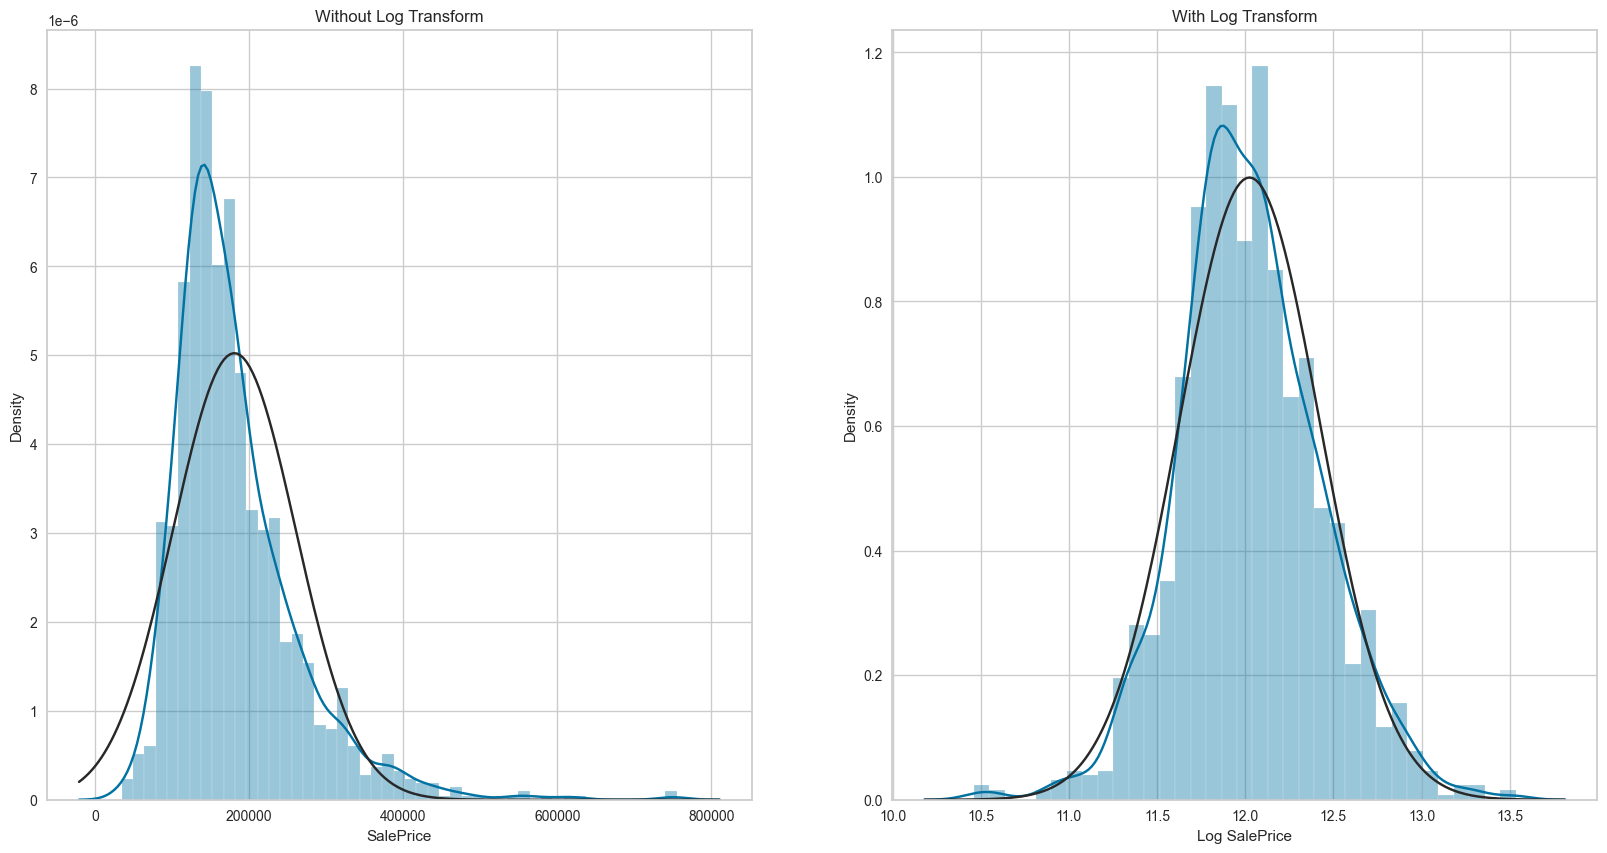

In [21]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.distplot(target, kde=True, fit=scipy.stats.norm)
plt.title("Without Log Transform")

plt.subplot(1, 2, 2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

In [22]:
log_target = np.log(target)

## 8. Data Splitting

In [23]:
# I like to consider it strictly ILLEGAL to ever ".fit()" some model on a combined train(ing)/test(ing) set

train_final = data5.loc[:train0.index.max(), :].copy()
test_final = data5.loc[train0.index.max() + 1:, :].reset_index(drop=True).copy()

In [24]:
train_final

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_N,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_N,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_N,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_N,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_N,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_N,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functiona

In [25]:
test_final

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_N,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_N,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_N,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_N,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_N,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_N,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functiona

# Pycaret's Model Selection

In [26]:
# _ = setup(data=pd.concat([train_final, log_target], axis=1), target='SalePrice')

In [27]:
# compare_models()

In [28]:
""" 
RESULTS:
1. catboost regressor (SAME)
2. gradient boosting regressor
3. light gradient boosting machine (SAME)
4. bayesian ridge (SAME)
5. extra trees regressor
-
6. extreme gradient boosting
7. random forest regressor
"""

' \nRESULTS:\n1. catboost regressor (SAME)\n2. gradient boosting regressor\n3. light gradient boosting machine (SAME)\n4. bayesian ridge (SAME)\n5. extra trees regressor\n-\n6. extreme gradient boosting\n7. random forest regressor\n'

## DELETED: Baseline Model

In [29]:
# baseline_model = CatBoostRegressor(verbose=0)

# baseline_model.fit(train_final, log_target)

## DELETED: Evaluate Baseline Model

In [30]:
# kf = KFold(n_splits=10) # -> 9/10 = Train(ing); 1/10 = Test(ing)

# results = cross_val_score(baseline_model, train_final, log_target, scoring="neg_mean_squared_error", cv=kf) # estimator, X, target

# -results

In [31]:
# np.exp(np.sqrt(np.mean(-results))) # this ".exp()" is here, thanks, to the feature's prior leveraging of ".log(1p)()"

In [32]:
# target.describe()

In [33]:
# log_target.describe()

## Optuna: Bayesian Ridge Hyper-parameter Optimization 

In [34]:
"""
def br_objective(trial):
    n_iter = trial.suggest_int('n_iter', 50, 600)
    tol = trial.suggest_loguniform('tol', 1e-8, 10.0)
    alpha_1 = trial.suggest_loguniform('alpha_1', 1e-8, 10.0)
    alpha_2 = trial.suggest_loguniform('alpha_2', 1e-8, 10.0)
    lambda_1 = trial.suggest_loguniform('lambda_1', 1e-8, 10.0)
    lambda_2 = trial.suggest_loguniform('lambda_2', 1e-8, 10.0)
    alpha_init = trial.suggest_loguniform('alpha_init', 1e-8, 10.0)
    lambda_init = trial.suggest_loguniform('lambda_init', 1e-8, 10.0)
    compute_score = trial.suggest_categorical('compute_score', ['True', 'False'])
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    copy_X = trial.suggest_categorical('copy_X', [True, False])
    verbose = trial.suggest_categorical('verbose', [True, False])
    normalize = trial.suggest_categorical('normalize', [True, False])

    model = BayesianRidge(
        n_iter=n_iter,
        tol=tol,
        alpha_1=alpha_1,
        alpha_2=alpha_2,
        lambda_1=lambda_1,
        lambda_2=lambda_2,
        alpha_init=alpha_init,
        lambda_init=lambda_init,
        compute_score=compute_score,
        fit_intercept=fit_intercept,
        copy_X=copy_X,
        verbose=verbose,
        normalize=normalize
    )

    model.fit(train_final, log_target)

    cv_scores = np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)))
    # this ".exp()" is here, thanks, to the feature's prior leveraging of ".log(1p)()"

    return np.mean(cv_scores)
"""

'\ndef br_objective(trial):\n    n_iter = trial.suggest_int(\'n_iter\', 50, 600)\n    tol = trial.suggest_loguniform(\'tol\', 1e-8, 10.0)\n    alpha_1 = trial.suggest_loguniform(\'alpha_1\', 1e-8, 10.0)\n    alpha_2 = trial.suggest_loguniform(\'alpha_2\', 1e-8, 10.0)\n    lambda_1 = trial.suggest_loguniform(\'lambda_1\', 1e-8, 10.0)\n    lambda_2 = trial.suggest_loguniform(\'lambda_2\', 1e-8, 10.0)\n    alpha_init = trial.suggest_loguniform(\'alpha_init\', 1e-8, 10.0)\n    lambda_init = trial.suggest_loguniform(\'lambda_init\', 1e-8, 10.0)\n    compute_score = trial.suggest_categorical(\'compute_score\', [\'True\', \'False\'])\n    fit_intercept = trial.suggest_categorical(\'fit_intercept\', [True, False])\n    copy_X = trial.suggest_categorical(\'copy_X\', [True, False])\n    verbose = trial.suggest_categorical(\'verbose\', [True, False])\n    normalize = trial.suggest_categorical(\'normalize\', [True, False])\n\n    model = BayesianRidge(\n        n_iter=n_iter,\n        tol=tol,\n  

In [35]:
#study = optuna.create_study(direction='minimize')
#study.optimize(br_objective, n_trials=100)

In [36]:
#study.best_params

## Optuna: Gradient Boosting Regressor Hyper-parameter Optimization

In [37]:
"""
def gbr_objective(trial):
    loss = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile'])
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 50, 600)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    min_weight_fraction_leaf = trial.suggest_uniform('min_weight_fraction_leaf', 0.0, 0.5)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_impurity_decrease = trial.suggest_uniform('min_impurity_decrease', 0.0, 0.5)
    init = trial.suggest_categorical('init', [None, 'zero'])
    random_state = trial.suggest_categorical('random_state', [None, 42, 2022])
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
    alpha = trial.suggest_uniform('alpha', 0.0, 0.99)
    verbose = trial.suggest_categorical('verbose', [0, 1, 2])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)
    warm_start = trial.suggest_categorical('warm_start', [True, False])
    validation_fraction = trial.suggest_uniform('validation_fraction', 0.1, 0.5)
    n_iter_no_change = trial.suggest_int('n_iter_no_change', 5, 20)
    tol = trial.suggest_loguniform('tol', 1e-5, 1e-2)
    ccp_alpha = trial.suggest_uniform('ccp_alpha', 0.0, 0.5)

    model = GradientBoostingRegressor(
        loss=loss,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        criterion=criterion,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_depth=max_depth,
        min_impurity_decrease=min_impurity_decrease,
        init=init,
        random_state=random_state,
        max_features=max_features,
        alpha=alpha,
        verbose=verbose,
        max_leaf_nodes=max_leaf_nodes,
        warm_start=warm_start,
        validation_fraction=validation_fraction,
        n_iter_no_change=n_iter_no_change,
        tol=tol,
        ccp_alpha=ccp_alpha
    )

    model.fit(train_final, log_target)

    cv_scores = np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)))

    return np.mean(cv_scores)
"""

"\ndef gbr_objective(trial):\n    loss = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile'])\n    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)\n    n_estimators = trial.suggest_int('n_estimators', 50, 600)\n    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)\n    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])\n    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)\n    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)\n    min_weight_fraction_leaf = trial.suggest_uniform('min_weight_fraction_leaf', 0.0, 0.5)\n    max_depth = trial.suggest_int('max_depth', 3, 10)\n    min_impurity_decrease = trial.suggest_uniform('min_impurity_decrease', 0.0, 0.5)\n    init = trial.suggest_categorical('init', [None, 'zero'])\n    random_state = trial.suggest_categorical('random_state', [None, 42, 2022])\n    max_features = trial.suggest_categorical('max_features', 

In [38]:
# study = optuna.create_study(direction='minimize')
# study.optimize(gbr_objective, n_trials=100)

In [39]:
# study.best_params

## Optuna: Extra Trees Regressor Hyper-parameter Optimization

In [40]:
"""
def et_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 600)
    criterion = trial.suggest_categorical('criterion', ['poisson', 'absolute_error', 'squared_error', 'friedman_mse'])
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    min_weight_fraction_leaf = trial.suggest_uniform('min_weight_fraction_leaf', 0.0, 0.5)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)
    min_impurity_decrease = trial.suggest_uniform('min_impurity_decrease', 0.0, 0.5)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    oob_score = trial.suggest_categorical('oob_score', [True, False]) if bootstrap else False
    n_jobs = trial.suggest_categorical('n_jobs', [-1, 1, 2, 4])
    random_state = trial.suggest_categorical('random_state', [None, 42, 2022])
    verbose = trial.suggest_categorical('verbose', [0, 1, 2])
    warm_start = trial.suggest_categorical('warm_start', [True, False])
    ccp_alpha = trial.suggest_uniform('ccp_alpha', 0.0, 0.5)
    max_samples = trial.suggest_uniform('max_samples', 0.1, 1.0) if bootstrap else None
    # monotonic_cst = trial.suggest_categorical('monotonic_cst', [None, 'increasing', 'decreasing'])

    model = ExtraTreesRegressor(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
        bootstrap=bootstrap,
        oob_score=oob_score,
        n_jobs=n_jobs,
        random_state=random_state,
        verbose=verbose,
        warm_start=warm_start,
        ccp_alpha=ccp_alpha,
        max_samples=max_samples,
        # monotonic_cst=monotonic_cst
    )

    model.fit(train_final, log_target)

    cv_scores = np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)))

    return np.mean(cv_scores)
"""

"\ndef et_objective(trial):\n    n_estimators = trial.suggest_int('n_estimators', 50, 600)\n    criterion = trial.suggest_categorical('criterion', ['poisson', 'absolute_error', 'squared_error', 'friedman_mse'])\n    max_depth = trial.suggest_int('max_depth', 3, 20)\n    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)\n    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)\n    min_weight_fraction_leaf = trial.suggest_uniform('min_weight_fraction_leaf', 0.0, 0.5)\n    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])\n    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)\n    min_impurity_decrease = trial.suggest_uniform('min_impurity_decrease', 0.0, 0.5)\n    bootstrap = trial.suggest_categorical('bootstrap', [True, False])\n    oob_score = trial.suggest_categorical('oob_score', [True, False]) if bootstrap else False\n    n_jobs = trial.suggest_categorical('n_jobs', [-1, 1, 2, 4])\n    random_state = trial.sugges

In [41]:
# study = optuna.create_study(direction='minimize')
# study.optimize(et_objective, n_trials=100)

In [42]:
# study.best_params

## Bagging Ensemble

In [43]:
# Optuna allegedly defines for us the ideal(?) hyper-parameters, shown below

catboost_params = {
    'iterations': 6000,
    'learning_rate': 0.005,
    'depth': 4,
    'l2_leaf_reg': 1,
    'eval_metric':'RMSE',
    'early_stopping_rounds': 200,
    'random_seed': 42
}

br_params = {
    'n_iter': 304,
    'tol': 0.16864712769300896,
    'alpha_1': 5.589616542154059e-07,
    'alpha_2': 9.799343618469923,
    'lambda_1': 1.7735725582463822,
    'lambda_2': 3.616928181181732e-06
}

lightgbm_params = {
    'num_leaves': 39,
    'max_depth': 2,
    'learning_rate': 0.13705339989856127,
    'n_estimators': 273,
}

"""
gbr_params = {
    'loss': 'absolute_error',
    'learning_rate': 0.11054616145386358,
    'n_estimators': 266,
    'subsample': 0.5902941839375372,
    'criterion': 'friedman_mse',
    'min_samples_split': 20,
    'min_samples_leaf': 10,
    'min_weight_fraction_leaf': 0.0175323040448155,
    'max_depth': 10,
    'min_impurity_decrease': 0.06678068552552889,
    'init': 'zero',
    'random_state': 2022,
    'max_features': 'sqrt',
    'alpha': 0.23585140032470903,
    'verbose': 2,
    'max_leaf_nodes': 15,
    'warm_start': False,
    'validation_fraction': 0.21488662066191244,
    'n_iter_no_change': 8,
    'tol': 0.0005401308587534491,
    'ccp_alpha': 0.00151895861887127
}

et_params = {
    'n_estimators': 531,
    'criterion': 'friedman_mse',
    'max_depth': 20,
    'min_samples_split': 3,
    'min_samples_leaf': 20,
    'min_weight_fraction_leaf': 0.09315416304656772,
    'max_features': 'sqrt',
    'max_leaf_nodes': 88,
    'min_impurity_decrease': 0.41028883629550056,
    'bootstrap': True,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 2022,
    'verbose': 1,
    'warm_start': True,
    'ccp_alpha': 0.0023371871861925567,
    'max_samples': 0.13295442632197021
}
"""

"\ngbr_params = {\n    'loss': 'absolute_error',\n    'learning_rate': 0.11054616145386358,\n    'n_estimators': 266,\n    'subsample': 0.5902941839375372,\n    'criterion': 'friedman_mse',\n    'min_samples_split': 20,\n    'min_samples_leaf': 10,\n    'min_weight_fraction_leaf': 0.0175323040448155,\n    'max_depth': 10,\n    'min_impurity_decrease': 0.06678068552552889,\n    'init': 'zero',\n    'random_state': 2022,\n    'max_features': 'sqrt',\n    'alpha': 0.23585140032470903,\n    'verbose': 2,\n    'max_leaf_nodes': 15,\n    'warm_start': False,\n    'validation_fraction': 0.21488662066191244,\n    'n_iter_no_change': 8,\n    'tol': 0.0005401308587534491,\n    'ccp_alpha': 0.00151895861887127\n}\n\net_params = {\n    'n_estimators': 531,\n    'criterion': 'friedman_mse',\n    'max_depth': 20,\n    'min_samples_split': 3,\n    'min_samples_leaf': 20,\n    'min_weight_fraction_leaf': 0.09315416304656772,\n    'max_features': 'sqrt',\n    'max_leaf_nodes': 88,\n    'min_impurity_de

In [44]:
"""
Define param_grids for each model

catboost_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [500, 1000, 1500],
    'random_strength': [0.1, 0.5, 1],
    'bagging_temperature': [0.5, 1, 1.5],
    'border_count': [32, 64, 128],
    'subsample': [0.5, 0.8, 1],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    'loss_function': ['RMSE', 'MAE', 'Quantile:alpha=0.95']
}

bayesian_ridge_param_grid = {
    'n_iter': [100, 300, 500],
    'tol': [1e-3, 1e-4, 1e-5],
    'alpha_1': [1e-6, 1e-7, 1e-8],
    'alpha_2': [1e-6, 1e-7, 1e-8],
    'lambda_1': [1e-6, 1e-7, 1e-8],
    'lambda_2': [1e-6, 1e-7, 1e-8]
}

lgbm_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'max_depth': [4, 6, 8],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
}
"""

gradient_boosting_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.5, 0.8, 1],
    'max_features': ['auto', 'sqrt', 'log2']
}

extra_trees_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [51]:
kf = KFold(n_splits=10)

# Define ms
ms = {
    "catboost": CatBoostRegressor(**catboost_params),
    "br": BayesianRidge(**br_params),
    "lightgbm": LGBMRegressor(**lightgbm_params),
}

# Evaluate ms
for name, m in ms.items():
    m.fit(train_final, log_target)
    print(name + " trained")

"""
# Define rs
rs = {}

for name, m in ms.items():
    r = np.exp(np.sqrt(-cross_val_score(m, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)))
    rs[name] = r

print(rs)

# Evaluate rs
for name, r in rs.items():
    print("----------\n" + name)
    print(np.mean(r))
    print(np.std(r))
"""

0:	learn: 0.3979953	total: 1.82ms	remaining: 10.9s
1:	learn: 0.3966883	total: 3.71ms	remaining: 11.1s
2:	learn: 0.3954577	total: 5.08ms	remaining: 10.2s
3:	learn: 0.3941907	total: 6.16ms	remaining: 9.23s
4:	learn: 0.3929835	total: 7.13ms	remaining: 8.55s
5:	learn: 0.3918451	total: 8.18ms	remaining: 8.17s
6:	learn: 0.3905819	total: 9.27ms	remaining: 7.93s
7:	learn: 0.3893567	total: 10.4ms	remaining: 7.79s
8:	learn: 0.3881118	total: 11.4ms	remaining: 7.6s
9:	learn: 0.3868492	total: 12.4ms	remaining: 7.41s
10:	learn: 0.3858000	total: 13.3ms	remaining: 7.23s
11:	learn: 0.3846392	total: 14.1ms	remaining: 7.05s
12:	learn: 0.3834028	total: 15ms	remaining: 6.91s
13:	learn: 0.3821739	total: 16ms	remaining: 6.82s
14:	learn: 0.3809574	total: 17ms	remaining: 6.79s
15:	learn: 0.3798507	total: 17.8ms	remaining: 6.67s
16:	learn: 0.3786481	total: 18.8ms	remaining: 6.6s
17:	learn: 0.3774288	total: 19.7ms	remaining: 6.53s
18:	learn: 0.3762467	total: 20.5ms	remaining: 6.47s
19:	learn: 0.3751650	total: 21

'\n# Define rs\nrs = {}\n\nfor name, m in ms.items():\n    r = np.exp(np.sqrt(-cross_val_score(m, train_final, log_target, scoring=\'neg_mean_squared_error\', cv=kf)))\n    rs[name] = r\n\nprint(rs)\n\n# Evaluate rs\nfor name, r in rs.items():\n    print("----------\n" + name)\n    print(np.mean(r))\n    print(np.std(r))\n'

In [46]:
""" ^^^
[RESULTS; cv = 10]:
----------
catboost (#1)
1.122340304394616
0.019942095909698854
----------
br (#3)
1.1351015144106285
0.02565664199126963
----------
lightgbm (#2)
1.1323401113019387
0.022377581009135113
"""

kf = KFold(n_splits=5)

# Define models
models = [
    ('GradientBoosting', GradientBoostingRegressor(), gradient_boosting_param_grid),
    ('ExtraTrees', ExtraTreesRegressor(), extra_trees_param_grid)
]

# Initialize results dictionary
results = {}

# Perform k-fold cross-validation for each model
for name, model, param_grid in models:
    print(f"Running GridSearchCV for {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(train_final, log_target)
    
    # Exponentiate predictions and target variable to reverse log transformation
    y_pred = np.exp(grid_search.predict(train_final))
    y_true = np.exp(log_target)
    
    # Compute RMSE score
    rmse_score = np.sqrt(mean_squared_error(y_true, y_pred))
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"Best params for {name}: {best_params}")
    print(f"Best RMSE score for {name}: {best_score}")
    print(f"RMSE score on training data for {name}: {rmse_score}\n")

    # Store RMSE scores in the results dictionary
    rmse_scores = np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = rmse_scores

Running GridSearchCV for GradientBoosting...
Best params for GradientBoosting: {'learning_rate': 0.05, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 1}
Best RMSE score for GradientBoosting: -0.014181648421777618
RMSE score on training data for GradientBoosting: 12051.717705119197

Running GridSearchCV for ExtraTrees...
Best params for ExtraTrees: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best RMSE score for ExtraTrees: -0.021397126017031944
RMSE score on training data for ExtraTrees: 1.1290949852996799e-08



## Evaluate Models

In [47]:
""" ^^^
[RESULTS; cv = 3]: 
Best params for GradientBoosting: {'learning_rate': 0.05, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 1}

Best RMSE score for GradientBoosting: -0.014732626317137123
RMSE score on training data for GradientBoosting: 11524.806061580774

Best RMSE score for ExtraTrees: -0.021956603868079138
RMSE score on training data for ExtraTrees: 1.1290949852996799e-08
"""

""" ^^^
[RESULTS; cv = 5]:
Best params for ExtraTrees: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Best RMSE score for GradientBoosting: -0.014181648421777618
RMSE score on training data for GradientBoosting: 12051.717705119197

Best RMSE score for ExtraTrees: -0.021397126017031944
RMSE score on training data for ExtraTrees: 1.1290949852996799e-08
"""

# Print or further analyze the results
for name, scores in results.items():
    print(f"Model: {name}")
    print(f"RMSE scores: {scores}")
    print(f"Mean RMSE: {np.mean(scores)}")
    print(f"Standard Deviation of RMSE: {np.std(scores)}")

Model: GradientBoosting
RMSE scores: [1.12752062 1.15025893 1.14513066 1.12399715 1.13833037]
Mean RMSE: 1.1370475473530295
Standard Deviation of RMSE: 0.010025948679718477
Model: ExtraTrees
RMSE scores: [1.12584935 1.1645177  1.16647413 1.12917204 1.14595987]
Mean RMSE: 1.146394619350057
Standard Deviation of RMSE: 0.017032598649793843


## Combine Predictions

In [57]:
""" ^^^
[RESULTS; cv = 5]:
Model: GradientBoosting
RMSE scores: [1.12752062 1.15025893 1.14513066 1.12399715 1.13833037]
Mean RMSE: 1.1370475473530295
Standard Deviation of RMSE: 0.010025948679718477
"""

""" ^^^
Model: ExtraTrees
RMSE scores: [1.12584935 1.1645177  1.16647413 1.12917204 1.14595987]
Mean RMSE: 1.146394619350057
Standard Deviation of RMSE: 0.017032598649793843
"""

from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor

# Best parameters for GradientBoostingRegressor
gb_params = {
    'learning_rate': 0.05,
    'max_depth': 4,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 300,
    'subsample': 1
}

# Best parameters for ExtraTreesRegressor
et_params = {
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 300
}

# Instantiate GradientBoostingRegressor and ExtraTreesRegressor with best parameters
best_gb_model = GradientBoostingRegressor(**gb_params)
best_et_model = ExtraTreesRegressor(**et_params)

# Fit the models to your training data
best_gb_model.fit(train_final, log_target)
best_et_model.fit(train_final, log_target)

ExtraTreesRegressor(max_features='sqrt', n_estimators=300)

## Prediction(s) Submission(s)

In [59]:
final_predictions = (
    0.2 * np.exp(ms['catboost'].predict(test_final)) +
    0.2 * np.exp(ms['br'].predict(test_final)) +
    0.2 * np.exp(ms['lightgbm'].predict(test_final)) +
    0.2 * np.exp(best_gb_model.predict(test_final)) +  
    0.2 * np.exp(best_et_model.predict(test_final))    
)

# print(final_predictions)

submission = pd.concat([test_ids, pd.Series(final_predictions, name='SalePrice')], axis=1)

submission.to_csv('./submission.csv', index=False, header=True)

# print(submission)

[124089.62934048 156716.24137897 181874.57827396 ... 157258.75352464
 115931.14053072 216762.26830902]
        Id      SalePrice
0     1461  124089.629340
1     1462  156716.241379
2     1463  181874.578274
3     1464  191759.339193
4     1465  189962.075524
...    ...            ...
1454  2915   87238.949366
1455  2916   82194.607351
1456  2917  157258.753525
1457  2918  115931.140531
1458  2919  216762.268309

[1459 rows x 2 columns]


In [ ]:
# 1. Score: 0.12312
# 2. Score: 0.12813
# 3. Score: 0.13826
# 4. Score: 0.12272 (BEST SCORE)